In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import expm, logm
from scipy.stats import norm
import statsmodels.api as sm
from scipy import integrate
%matplotlib inline

In [2]:
%%capture
from tqdm.notebook import trange, tqdm
tqdm().pandas()

The computation of the matrix exponential is performed using the Pade approximation:

Reference:

Awad H. Al-Mohy and Nicholas J. Higham (2009) “A New Scaling and Squaring Algorithm for the Matrix Exponential.” SIAM Journal on Matrix Analysis and Applications. 31 (3). pp. 970-989. ISSN 1095-7162

## Loading income data
**Dataset**: rfamxxxx.csv

**Years**: 1998 to 2012 (only even years)

**Variables**:
- *ANNO*: Year
- *NQUEST*: Household ID
- *Y1*: Net disposable income (w/o financial assets)
- *Y2*: Net disposable income

**Note**: data contain a currency shift from thousands of Italian Lire (until 2000) to Euro (from 2002) (1 Euro = 1936.27 Italian Lire).

In [3]:
years = [1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012]
rfam = []
for year in years:
    print(year, end=' ')
    df = pd.read_csv(f'data.nosync/rfam{year}.csv')
    # convert the Italian Lire to Euro for years 1998 and 2000
    if year in [1998, 2000]:
        df['Y2'] = df['Y2']*1000/1936.27
        df['Y1'] = df['Y1']*1000/1936.27
    # rename income to Y_xxxx
    #df.rename(columns={'Y2':f'Y'}, inplace=True)
    # fix the lower-case header for 2008 and 2012
    if year in [2008, 2012]:
        df.rename(columns={'nquest':'NQUEST'}, inplace=True)
    # filter only columns of interest
    df = df[['ANNO','NQUEST','Y1','Y2']]
    rfam.append(df)
rfam = pd.concat(rfam)

1998 2000 2002 2004 2006 2008 2010 2012 

In [4]:
rfam

,ANNO,NQUEST,Y1,Y2
0,1998,34,80050.819359,79761.603495
1,1998,123,6197.482789,1323.722054
2,1998,173,20761.567343,21034.256586
3,1998,304,12911.422477,13820.386620
4,1998,325,15803.581112,16236.758806
...,...,...,...,...
8146,2012,889749,21778.000000,21956.020998
8147,2012,889750,14800.000000,14925.801505
8148,2012,889751,26000.000000,26178.020998
8149,2012,889752,23100.000000,23131.980055


In [5]:
# descriptive stats for the original dataset
rfam[['Y1','Y2']].describe()

,Y1,Y2
count,6.301800e+04,6.301800e+04
mean,2.974698e+04,3.018494e+04
std,2.340649e+04,2.426811e+04
min,-4.338238e+04,-4.157511e+04
25%,1.598792e+04,1.601016e+04
50%,2.460000e+04,2.482162e+04
75%,3.760000e+04,3.801351e+04
max,1.024568e+06,1.022617e+06


In [6]:
# find negative income
rfam[(rfam['Y1']<0)|(rfam['Y2']<0)]

,ANNO,NQUEST,Y1,Y2
50,1998,4370,-43382.379524,-39084.425209
513,1998,29421,-13796.115387,-13796.115387
1007,1998,34224,-68.370257,352.868994
4099,1998,505327,-39297.205452,-39669.054419
4279,1998,505782,-8890.723463,-6432.737098
4657,1998,506714,-19701.663105,-18672.880962
700,2000,33781,1394.433628,-201.521482
4002,2000,611518,1859.244837,-693.085159
897,2004,91043,-5705.949686,-5693.503837
1313,2004,506132,-6400.000000,-6214.114000


In [7]:
# remove households with negative Y2
neg_nquest = rfam[(rfam['Y2']<0)]['NQUEST']
rfam = rfam[~rfam['NQUEST'].isin(neg_nquest)]
rfam.describe()

,ANNO,NQUEST,Y1,Y2
count,62970.000000,62970.000000,6.297000e+04,6.297000e+04
mean,2005.103128,589955.788709,2.975999e+04,3.019834e+04
std,4.554906,251264.679405,2.340156e+04,2.426357e+04
min,1998.000000,34.000000,-6.837026e+01,0.000000e+00
25%,2002.000000,507960.500000,1.599471e+04,1.601164e+04
50%,2006.000000,675289.500000,2.460000e+04,2.482650e+04
75%,2010.000000,724353.000000,3.760000e+04,3.802577e+04
max,2012.000000,889753.000000,1.024568e+06,1.022617e+06


## Load info dataset

**Dataset**: compxxxx.csv

**Variables**:
- *ANNO*: year
- *NQUEST*: Household ID
- *NCOMP*: Number of household members
- *AREA3*: 1=North, 2=Centre, 3=South and Islands
- *SESSO*: Sex
- *ETA*: Age(years)
- *ETA5*: Age groups:
    - 1 = up to 30 years
    - 2 = from 31 to 40 years
    - 3 = from 41 to 50 years
    - 4 = from 51 to 65 years
    - 5 = more than 65 years
- *STUDIO*: Educational qualification: 
    - 1 = none
    - 2 = elementary school
    - 3 = middle school
    - 4 = high school
    - 5 = bachelor’s degree
    - 6 = post-graduate qualification.

In [8]:
cols = ['ANNO','NQUEST','NCOMP','AREA3']
comp = []
for year in years:
    print(year, end=' ')
    df = pd.read_csv(f'data.nosync/comp{year}.csv')
    # fix the lower-case header for 2012
    if year in [2012]:
        df.rename(columns={'nquest':'NQUEST'}, inplace=True)
    # create the dataset with the value counts of the Age group
    A5 = df.groupby('NQUEST')['ETA5'].value_counts().to_frame().rename(columns={'ETA5':'COUNT'}).reset_index()
    A5 = pd.pivot_table(A5, values='COUNT', index='NQUEST', columns='ETA5')
    A5.columns = ['A'+str(x+1) for x in range(5)]
    A5.reset_index(inplace=True)
    A5 = A5.fillna(0).astype(dtype='int')
    # filter only columns of interest and drop duplicates
    df = df[cols].drop_duplicates()
    if len(df)-len(A5):
        print('ERROR while merging A5 with df')
    # join df with A5
    df = pd.merge(df, A5, how='left', on='NQUEST')
    # join datasets
    comp.append(df)
comp = pd.concat(comp)

1998 2000 2002 2004 2006 2008 2010 2012 

In [9]:
comp

,ANNO,NQUEST,NCOMP,AREA3,A1,A2,A3,A4,A5
0,1998,34,4,1,2,0,0,2,0
1,1998,123,4,3,2,0,0,2,0
2,1998,173,4,3,2,0,2,0,0
3,1998,304,3,3,1,2,0,0,0
4,1998,325,2,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
8146,2012,889749,3,3,1,0,0,0,2
8147,2012,889750,1,1,1,0,0,0,0
8148,2012,889751,2,1,2,0,0,0,0
8149,2012,889752,4,3,2,0,0,2,0


## Load poverty lines

In [10]:
pov = pd.read_csv('data.nosync/poverty lines.csv')
# convert the Italian Lire to Euro for years before 2000
pov.loc[:,'1997':'2000'] = pov.loc[:,'1997':'2000']/1936.27
pov = pov.set_index('NCOMP').unstack().to_frame().reset_index()
pov.columns = ['ANNO','COMP','Yp']
pov['Yp'] = pov['Yp']*12
pov['ANNO'] = pov['ANNO'].astype(dtype='int')
# drop 1997 observations
pov = pov[pov['ANNO']>1997].reset_index(drop=True)
# compute scale factor for income across number of components
pov['Yscale'] = (pov.set_index('ANNO')['Yp']/pov.groupby('ANNO')['Yp'].first()).reset_index(drop=True)
# compute scale factor for income over time
time_scale = (pov.groupby('ANNO')['Yp'].first()/pov.groupby('ANNO')['Yp'].first().loc[1998]).to_frame()
time_scale.columns = ['Tscale']
pov = pov.merge(time_scale, how='left', left_on=['ANNO'], right_index=True)
pov

,ANNO,COMP,Yp,Yscale,Tscale
0,1998,1,5479.498210,1.000000,1.000000
1,1998,2,9147.744891,1.669449,1.000000
2,1998,3,12212.238996,2.228715,1.000000
3,1998,4,14929.122488,2.724542,1.000000
4,1998,5,17426.453955,3.180301,1.000000
...,...,...,...,...,...
107,2013,3,15521.400000,2.216672,1.277876
108,2013,4,19022.520000,2.716680,1.277876
109,2013,5,22173.480000,3.166681,1.277876
110,2013,6,25207.680000,3.600007,1.277876


### Evolution of poverty thresholds 

In [11]:
pov.pivot_table(values='Yp', index=['ANNO'], columns=['COMP'])

COMP,1,2,3,4,5,6,7
ANNO,,,,,,,
1998,5479.498210,9147.744891,12212.238996,14929.122488,17426.453955,19667.649656,21963.736462
1999,5549.157917,9248.596528,12300.633693,15075.209552,17572.336503,19884.480987,22196.631668
2000,5833.535612,9722.555222,12930.998260,15847.762967,18472.855542,21000.722007,23334.130054
2001,5864.760000,9774.600000,13000.320000,15932.640000,18571.800000,21113.160000,23459.160000
2002,5919.600000,9866.040000,13121.880000,16081.680000,18745.440000,21310.680000,23678.520000
2003,6298.080000,10496.880000,13960.800000,17109.960000,19944.120000,22673.280000,25192.560000
2004,6623.880000,11039.760000,14682.840000,17994.840000,20975.520000,23845.920000,26495.400000
2005,6743.400000,11238.960000,14947.800000,18319.560000,21354.000000,24276.120000,26973.480000
2006,6986.400000,11644.080000,15486.600000,18979.800000,22123.800000,25151.160000,27945.840000


## Combine the datasets and compute poverty classes

In [12]:
df = pd.merge(rfam, comp, how='left', on=['ANNO','NQUEST'])
# adjust NCOMP to have max 7 categories by components to merge with poverty thresholds
df['COMP'] = df['NCOMP'].mask(df['NCOMP']>7,7)
# combine df with poverty thersholds
df = pd.merge(df, pov, how='left', on=['ANNO','COMP'])
# compute exterme poverty thershold as % of Yp
Yp_perc = .6 # NOTE: changing this value to <.6 causes the generator matrix to have a negative value outside the diagonal
df['Yep'] = Yp_perc*df['Yp']
# use the base threshold for 1 person in 1998 for Ye
yp = pov.loc[0,'Yp']
# compute the poverty classes
df['C'] = 2
df['C'] = df['C'].mask(df['Y2']<=df['Yp'], 1)
df['C'] = df['C'].mask(df['Y2']<=df['Yep'], 0)
# compute equivalent incomes and classes
df['Ye'] = df['Y2']/df['Yscale']/df['Tscale']
df['Ce'] = 2
df['Ce'] = df['Ce'].mask(df['Ye']<=yp, 1)
df['Ce'] = df['Ce'].mask(df['Ye']<=Yp_perc*yp, 0)
df

,ANNO,NQUEST,Y1,Y2,NCOMP,AREA3,A1,A2,A3,A4,A5,COMP,Yp,Yscale,Tscale,Yep,C,Ye,Ce
0,1998,34,80050.819359,79761.603495,4,1,2,0,0,2,0,4,14929.122488,2.724542,1.00000,8957.473493,2,29275.234627,2
1,1998,123,6197.482789,1323.722054,4,3,2,0,0,2,0,4,14929.122488,2.724542,1.00000,8957.473493,0,485.851237,0
2,1998,173,20761.567343,21034.256586,4,3,2,0,2,0,0,4,14929.122488,2.724542,1.00000,8957.473493,2,7720.291090,2
3,1998,304,12911.422477,13820.386620,3,3,1,2,0,0,0,3,12212.238996,2.228715,1.00000,7327.343397,2,6201.056479,2
4,1998,325,15803.581112,16236.758806,2,1,0,1,0,1,0,2,9147.744891,1.669449,1.00000,5488.646935,2,9725.816787,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62965,2012,889749,21778.000000,21956.020998,3,3,1,0,0,0,2,3,15814.440000,2.216659,1.30201,9488.664000,2,7607.476317,2
62966,2012,889750,14800.000000,14925.801505,1,1,1,0,0,0,0,1,7134.360000,1.000000,1.30201,4280.616000,2,11463.663543,2
62967,2012,889751,26000.000000,26178.020998,2,1,2,0,0,0,0,2,11890.560000,1.666661,1.30201,7134.336000,2,12063.554552,2
62968,2012,889752,23100.000000,23131.980055,4,3,2,0,0,2,0,4,19381.560000,2.716650,1.30201,11628.936000,2,6539.806048,2


## Analysis of trajectories
### Filter the dataset to exclude single year income and gaps between years

In [13]:
# Create a table with all sequence (for filtering df)
Y = df.pivot_table(values='Ye', columns=['ANNO'], index=['NQUEST'])
Y

ANNO,1998,2000,2002,2004,2006,2008,2010,2012
NQUEST,,,,,,,,
34,29275.234627,27435.215612,35283.873183,45105.134705,NaN,NaN,NaN,NaN
123,485.851237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,7720.291090,8341.399201,10083.540404,8069.352246,10654.437571,15624.923005,15306.150503,38200.452796
304,6201.056479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,9725.816787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
889749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7607.476317
889750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11463.663543
889751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12063.554552


In [14]:
# get the households index with complete trajectories from 1998 to 2012
nquest_index_full_traj = Y.dropna().index
# filter the dataframe
df = df[df['NQUEST'].isin(nquest_index_full_traj)]
print('Number of housholds with complete trajectories from 1998 to 2012:', len(df['NQUEST'].unique()))

Number of housholds with complete trajectories from 1998 to 2012: 914


## Descriptive statistics

### Income stats by poverty class

In [15]:
df.groupby(['Ce'])['Ye'].describe()

,count,mean,std,min,25%,50%,75%,max
Ce,,,,,,,,
0,182.0,2136.624575,977.946211,0.000000,1509.418493,2354.288430,2941.385491,3285.675950
1,416.0,4488.465594,613.019030,3293.410453,4020.485061,4529.341212,5001.677592,5467.459496
2,6714.0,14802.988481,9023.689975,5480.918194,9360.715950,12870.518301,17698.428174,222822.468181


### Income stats by poverty class and year

In [16]:
df.groupby(['Ce','ANNO'])['Ye'].describe()

count          mean           std          min          25%  \
Ce ANNO                                                                
0  1998   46.0   1906.734739   1096.034067     0.000000  1119.601594   
   2000   31.0   2412.197871    807.849269     0.000000  1956.283342   
   2002   22.0   1823.741966   1142.108852     0.000000   789.239685   
   2004   19.0   2416.543807    876.408657   411.080209  2197.941732   
   2006   17.0   2475.846601    674.059190  1040.232351  2122.931390   
   2008   14.0   1984.402103   1050.651394     0.000000  1446.137828   
   2010   18.0   2027.804249    932.763382     0.000000  1411.324163   
   2012   15.0   2264.639132    873.069011     0.000000  1785.363923   
1  1998   62.0   4448.508265    601.148614  3336.891379  3910.484620   
   2000   63.0   4421.282362    603.666045  3315.210131  3938.343388   
   2002   56.0   4420.463071    638.627649  3332.338939  3915.284323   
   2004   62.0   4524.568906    642.311254  3310.862763  4071.301897   
   2006   51.0   4601.904652    573.251881  3293.410453  4298.562977   
   2008   51.0   4400.475540    622.477566  3335.142834  3931.387740   
   2010   26.0   4484.751904    584.145331  3390.032960  4047.448620   
   2012   45.0   4645.760940    612.274826  3348.036363  4275.649844   
2  1998  806.0  13937.281753   8618.749076  5521.504848  8835.967243   
   2000  820.0  14073.521589   7377.342275  5480.918194  8970.604421   
   2002  836.0  15037.321930   8912.135318  5516.687113  9578.788602   
   2004  833.0  14365.631080   7923.842876  5516.823005  9175.147181   
   2006  846.0  14782.959423  10910.312494  5500.277520  9342.044296   
   2008  849.0  14876.237599   7952.668817  5519.171686  9635.962685   
   2010  870.0  15575.136786  10365.521874  5500.378894  9637.067954   
   2012  854.0  15678.076872   9293.901858  5494.801372  9743.480759   

                  50%           75%            max  
Ce ANNO                                             
0  1998   2064.372314   2877.754271    3247.849117  
   2000   2626.177436   3138.188231    3285.675950  
   2002   1992.876232   2878.215565    3257.161782  
   2004   2910.886861   3043.465731    3240.318302  
   2006   2641.619439   3009.083129    3282.410308  
   2008   2368.024546   2727.619177    3197.429108  
   2010   2309.804023   2728.061359    3229.264393  
   2012   2381.465832   2954.674229    3169.786695  
1  1998   4509.735926   4880.583859    5442.191053  
   2000   4457.935984   4954.666562    5443.554580  
   2002   4358.649592   4959.653965    5431.651339  
   2004   4579.718243   5071.807861    5446.651660  
   2006   4692.081994   5020.890612    5466.548329  
   2008   4387.651247   4859.260991    5467.459496  
   2010   4543.818864   4880.210010    5425.045462  
   2012   4754.834247   5192.865870    5445.969362  
2  1998  11910.251356  16551.301740  107014.106524  
   2000  12461.068895  17035.409308   79841.988492  
   2002  12766.476923  18108.147676  112369.431371  
   2004  12416.790275  17199.283006   83560.501043  
   2006  12648.495630  17424.164074  222822.468181  
   2008  13183.655794  17786.767047   83096.301831  
   2010  13705.605594  18539.611641  200125.836408  
   2012  13756.484361  18618.779636  108752.974953

### Percentage of households in each poverty class

In [17]:
df.groupby(['C'])['Ye'].count()/len(df)

C
0    0.024891
1    0.056893
2    0.918217
Name: Ye, dtype: float64

### Percentage of households in each poverty class by year

In [18]:
df.groupby(['ANNO','C'])['Ye'].count()/df.groupby(['ANNO'])['Ye'].count()

ANNO  C
1998  0    0.050328
      1    0.067834
      2    0.881838
2000  0    0.033917
      1    0.068928
      2    0.897155
2002  0    0.024070
      1    0.061269
      2    0.914661
2004  0    0.020788
      1    0.067834
      2    0.911379
2006  0    0.018600
      1    0.055799
      2    0.925602
2008  0    0.015317
      1    0.055799
      2    0.928884
2010  0    0.019694
      1    0.028446
      2    0.951860
2012  0    0.016411
      1    0.049234
      2    0.934354
Name: Ye, dtype: float64

## Function for indexes computation

In [19]:
# create multiindex for probability matrix
def P_index(m):
    tuples = []
    for i in range(m):
        for j in range(m):
            tuples.append((i,j))
    index = pd.MultiIndex.from_tuples(tuples, names=['i', 'j'])
    return index

# transition probability matrix
def get_P(df):
    prob = df.copy()
    prob.columns = ['NQUEST','i']
    prob['j'] = prob.groupby('NQUEST')['i'].shift(-1)
    prob = prob.dropna() # eliminate the last obs for each group
    prob['j'] = prob['j'].astype(dtype='int')
    prob = prob[['i','j']]
    prob['p_ij'] = 1
    prob = prob.groupby(['i','j']).count()
    prob['p_ij'] = prob.groupby(prob.index.get_level_values('i'))['p_ij'].transform(lambda x: x/x.sum())
    prob = prob.reindex(P_index(3), fill_value=0)
    P_hat = np.array(prob.iloc[:,0]).reshape(3, 3)
    return P_hat

# computation of the integral for the variance for Gini index
# integral approximation using the discrete distribution with n bins
def integral_gini_sigma(df, nbins=100):
    freq, values = np.histogram(df['Ye'], bins=nbins)
    prob = list(freq/np.sum(freq))
    resy = 0
    for iy, dy in enumerate(values[1:]):
        resx = 0
        for ix, dx in enumerate(values[1:]):
            resx += np.abs(dy-dx)*prob[ix]
        resy += (resx**2)*prob[iy]
    return resy

# computation of the poverty indexes and their variances
def poverty_indexes(P, mu, y, y2, y_p, yx, int_sigma1, int_sigma2):
    mP = mu_1998.T.dot(P)[0]
    # Headcount ratio
    Ht = mP[:2].sum()
    varH = Ht*(1-Ht)
    # Income gap
    It = 1-((y[0]*mP[0]+y[1]*mP[1])/(yp*Ht))
    sigma2_I = y2[0]*mP[0]+y2[1]*mP[1]-(y[0]*mP[0]+y[1]*mP[1])**2
    varI = sigma2_I/(yp*Ht)**2
    # Gini
    Gt_num = mP[0]**2*yx[0] + 2*(y[1]-y[0])*mP[0]*mP[1] + mP[1]**2*yx[1]
    Gt_den = 2*Ht*(y[0]*mP[0] + y[1]*mP[1])
    Gt = Gt_num/Gt_den
    int_sigma = mP[0]**3*int_sigma1 + mP[0]**2*mP[1]*(y[0]-y[1])**2 + mP[1]**2*mP[0]*(y[0]-y[1])**2 + mP[1]**3*int_sigma2
    sigma2_G = int_sigma - Gt_num**2
    varG = sigma2_G/Gt_den**2
    # Sen
    St = Ht*(It+(1-It)*Gt)
    varS = (1-Ht)*St**2/Ht
    return [Ht, It, Gt, St], [varH, varI, varG, varS]

# computation of confidence intervals
def conf_intervals(indexes, var, N, alpha=0.05):
    z = norm.ppf(1-alpha/2)
    # headcount ratio
    H = indexes[0]
    var_H = var[0]
    ci_H = [H+sign*z*np.sqrt(var_H/N) for sign in [-1,1]]
    # Income gap
    I = indexes[1]
    var_I = var[1] 
    ci_I = [I+sign*z*np.sqrt(var_I/N) for sign in [-1,1]]
    # Gini
    G = indexes[2]
    var_G = var[2]
    ci_G = [G+sign*z*np.sqrt(var_G/N) for sign in [-1,1]]
    # Sen
    S = indexes[3]
    var_S = var[3] 
    ci_S = [S+sign*z*np.sqrt(var_S/N) for sign in [-1,1]]
    return [ci_H[0],ci_H[1],ci_I[0],ci_I[1],ci_G[0],ci_G[1],ci_S[0],ci_S[1]]

# computation of the asymptotic indexes
def poverty_indexes_inf(G, y, y_p, yx):
    Pinf = expm(10e9*G)[0]
    Hinf = Pinf[:2].sum()
    Iinf = (yp-y[0])/yp*Pinf[0]/Hinf+(yp-y[1])/yp*Pinf[1]/Hinf
    Ginf = (Pinf[0]**2*yx[0] + 2*(y[1]-y[0])*Pinf[0]*Pinf[1] + Pinf[1]**2*yx[1])/(2*Hinf*(y[0]*Pinf[0]+y[1]*Pinf[1]))
    Sinf = Hinf*(Iinf+(1-Iinf)*Ginf)
    return [Hinf, Iinf, Ginf, Sinf]

## Poverty indexes

In [20]:
P_hat = get_P(df[['NQUEST','Ce']])
print('Transition probability matrix')
print(P_hat)

G_hat = (logm(P_hat)/2) # equation (3.6)
print('Generator Matrix')
print(G_hat)

# estimate initial distribution using only 1998
mu_1998 = np.array(df[df['ANNO']==1998].groupby('Ce')['Ce'].count()/len(df[df['ANNO']==1998])).reshape(3,1)
print('Initial distribution')
print(mu_1998)

y = df.groupby('Ce')['Ye'].mean().tolist()
print('Average income by class:', y)
print('Poverty threshold:', yp)
print('Extreme Poverty threshold:', Yp_perc*yp)
# save the number of households
hh = len(df['NQUEST'].unique())
print('N:', hh)
# compute integral for gini variance
int_gini_sigma_1 = integral_gini_sigma(df[(df['Ce']==0)])
int_gini_sigma_2 = integral_gini_sigma(df[(df['Ce']==1)])
# average of |y-x|
yx = df.groupby('Ce')['Ye'].apply(lambda s: s.apply(lambda x: np.abs(x-s)).mean().mean()).to_list()
# second moment of income distribution
y2 = (df['Ye']**2).groupby(df['Ce']).mean().tolist()

# computation of poverty indexes based on generator matrix G and initial ditribution mu
poverty = []
i = []
for t in range(1998,2014):
    P = expm((t-1997)*G_hat)
    sub_df = df[(df['Ce']<2)&(df['ANNO']==t)].copy()
#     if not sub_df.empty:
#         int_gini = integral_gini(sub_df)
#         int_gini_0 = integral_gini(sub_df[sub_df['Ce']==0])
#         int_gini_1 = integral_gini(sub_df[sub_df['Ce']==1])
#         int_gini_sigma = integral_gini_sigma(sub_df)
#         int_gini_sigma2 = integral_gini_sigma2(sub_df, mu_1998, P)
#         # variable average income and N (comment out for fixed)

        # compute income average for each class
#         y = sub_df.groupby('Ce')['Ye'].mean().reindex([0,1]).fillna(0).tolist()
        # compute averate of |y-x| for each class
#         yx = df[(df['ANNO']==t)].groupby('Ce')['Ye'].apply(lambda s: s.apply(lambda x: np.abs(x-s)).mean().mean()).to_list()
        # hh = len(df[df['ANNO']==t]['NQUEST'].unique()) # same results as outside the for loop

    I, var = poverty_indexes(P, mu_1998, y, y2, [Yp_perc*yp, yp], yx, int_gini_sigma_1, int_gini_sigma_2)
    CI = conf_intervals(I, var, hh) # hh is the number of households
    # asymptotic indexes
    I_inf = poverty_indexes_inf(G_hat, y, [Yp_perc*yp, yp], yx)
    poverty.append(I+CI+I_inf)
    i.append(t)
poverty = pd.DataFrame(poverty, columns=['H','I','G','S','H_L','H_U','I_L','I_U','G_L','G_U','S_L','S_U','H_inf','I_inf','G_inf','S_inf'], index=i)
# observed indexes
poverty['H_obs'] = (df[df['Ce']<2].groupby(['ANNO'])['Ye'].count()/df.groupby(['ANNO'])['Ye'].count())
poverty['I_obs'] = 1-df[df['Ce']<2].groupby('ANNO')['Ye'].sum()/(yp*df[df['Ce']<2].groupby(['ANNO'])['Ye'].count())
poverty['G_obs'] = df[(df['Ce']<2)].groupby('ANNO').apply(lambda h: h['Ye'].apply(lambda l: np.abs(l-h['Ye']).sum()).sum())/(2*df[df['Ce']<2].groupby(['ANNO'])['Ye'].count()*df[df['Ce']<2].groupby('ANNO')['Ye'].sum())
poverty['S_obs'] = poverty['H_obs']*(poverty['I_obs']+(1-poverty['I_obs'])*poverty['G_obs'])
# interpolate missing observed values
poverty.interpolate(inplace=True)
poverty

Transition probability matrix
[[0.37125749 0.38323353 0.24550898]
 [0.11051213 0.37735849 0.51212938]
 [0.0056314  0.02559727 0.96877133]]
Generator Matrix
[[-0.58614552  0.57815529  0.00799023]
 [ 0.16557019 -0.58942771  0.42385752]
 [ 0.00198006  0.02032391 -0.02230396]]
Initial distribution
[[0.05032823]
 [0.0678337 ]
 [0.88183807]]
Average income by class: [2136.624575363375, 4488.465593887247, 14802.98848149619]
Poverty threshold: 5479.498210476844
Extreme Poverty threshold: 3287.6989262861066
N: 914


,H,I,G,S,H_L,H_U,I_L,I_U,G_L,G_U,S_L,S_U,H_inf,I_inf,G_inf,S_inf,H_obs,I_obs,G_obs,S_obs
1998,0.108093,0.332016,0.205313,0.050713,0.087964,0.128223,0.198388,0.465644,0.175591,0.235036,0.041269,0.060157,0.065792,0.291451,0.175145,0.02734,0.118162,0.385728,0.251355,0.063823
1999,0.098605,0.316439,0.194129,0.044287,0.079277,0.117933,0.173472,0.459407,0.163984,0.224273,0.035606,0.052968,0.065792,0.291451,0.175145,0.02734,0.110503,0.349885,0.211563,0.054119
2000,0.090738,0.308076,0.187913,0.039752,0.072117,0.109360,0.157130,0.459022,0.156995,0.218830,0.031594,0.047910,0.065792,0.291451,0.175145,0.02734,0.102845,0.314041,0.171771,0.044415
2001,0.084560,0.303160,0.184194,0.036489,0.066523,0.102598,0.145515,0.460806,0.152449,0.215938,0.028706,0.044272,0.065792,0.291451,0.175145,0.02734,0.094092,0.320488,0.189446,0.042106
2002,0.079834,0.300003,0.181779,0.034109,0.062263,0.097405,0.136849,0.463157,0.149284,0.214275,0.026602,0.041616,0.065792,0.291451,0.175145,0.02734,0.085339,0.326936,0.207121,0.039797
2003,0.076267,0.297821,0.180100,0.032359,0.059059,0.093474,0.130227,0.465416,0.146973,0.213228,0.025058,0.039659,0.065792,0.291451,0.175145,0.02734,0.086980,0.295725,0.180140,0.036611
2004,0.073593,0.296239,0.178876,0.031065,0.056665,0.090520,0.125126,0.467352,0.145241,0.212512,0.023920,0.038211,0.065792,0.291451,0.175145,0.02734,0.088621,0.264514,0.153160,0.033425
2005,0.071596,0.295059,0.177961,0.030107,0.054882,0.088311,0.121198,0.468920,0.143928,0.211994,0.023078,0.037136,0.065792,0.291451,0.175145,0.02734,0.081510,0.260837,0.150226,0.030349
2006,0.070109,0.294169,0.177269,0.029396,0.053556,0.086662,0.118185,0.470153,0.142929,0.211608,0.022455,0.036336,0.065792,0.291451,0.175145,0.02734,0.074398,0.257160,0.147291,0.027272
2007,0.069001,0.293495,0.176743,0.028868,0.052570,0.085433,0.115887,0.471103,0.142171,0.211315,0.021993,0.035742,0.065792,0.291451,0.175145,0.02734,0.072757,0.274525,0.157588,0.028242


## Plots

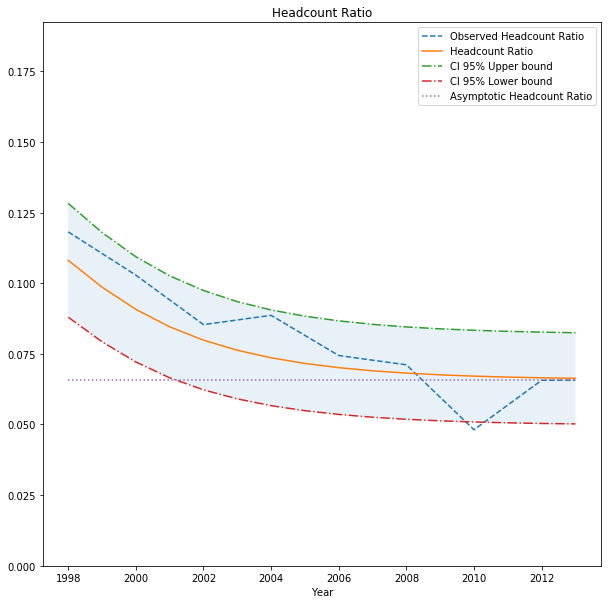

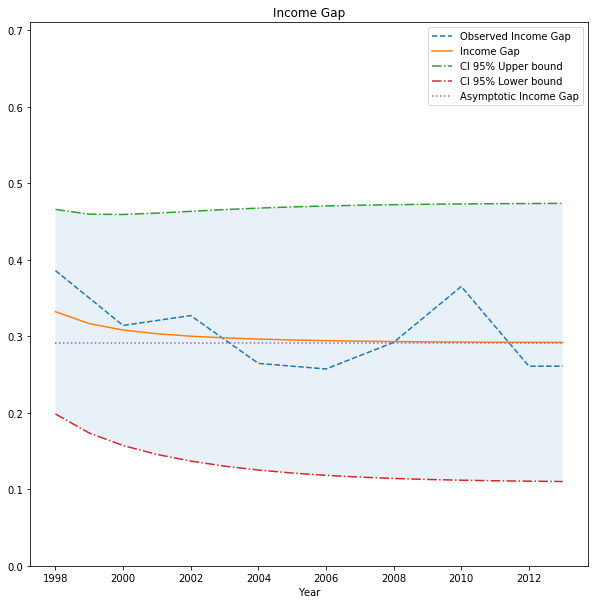

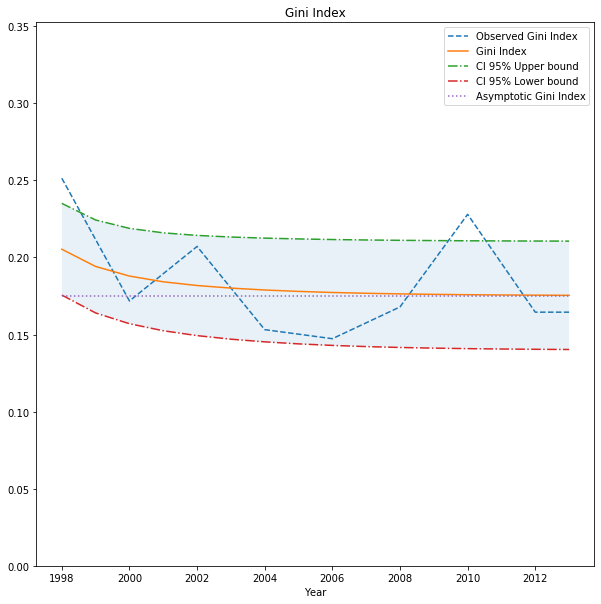

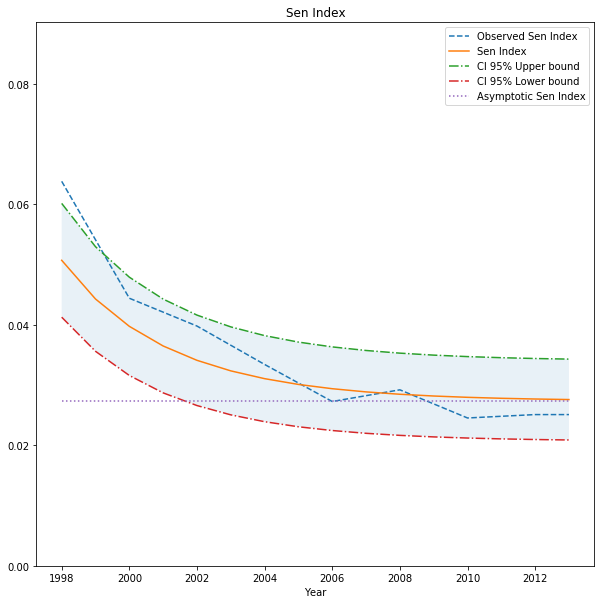

In [21]:
for i, title in {'H':'Headcount Ratio','I':'Income Gap','G':'Gini Index','S':'Sen Index'}.items():
    ax = poverty[[i+'_obs',i,i+'_U',i+'_L',i+'_inf']].ffill().plot(figsize=(10,10), style={i+'_obs':'--',i:'-',i+'_L':'-.',i+'_U':'-.',i+'_inf':':'},
                                                              title=title)
    ax.legend(('Observed '+title, title, 'CI 95% Upper bound', 'CI 95% Lower bound', 'Asymptotic '+title))
    ax.fill_between(poverty.index, poverty[i+'_U'], poverty[i+'_L'], alpha=0.1)
    ax.set_xlabel('Year')
    ax.set_ylim([0,poverty[i+'_U'].max()*1.5])